importd and loading dataset

In [28]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product

# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Datasets and DataLoaders
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


now the the Neural Network with one hidden layer

In [29]:
class oneHidden_noconv(nn.Module):
    def __init__(self, hiddendim=512):
        super(oneHidden_noconv, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, hiddendim) 
        self.ReLU = nn.ReLU ()
        self.fc2 = nn.Linear(hiddendim, 10)
        # inpu to hidden layer, ReLU to output layer of 10 classes

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input into a 1 dimensional vecotr
        x = self.fc1(x)
        x=self.ReLU(x)
        x=self.fc2(x)
        return x


loss calculation and optimisor initialisation

In [30]:
net = oneHidden_noconv()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

training loop

In [31]:
train_loss_list = []
test_acc_list = []
log_interval = 1000

for epoch in range(2):
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(enumerate(trainloader, 0), total=len(trainloader), desc=f"Epoch {epoch+1}") #for progress bar

    for i, data in loop:
        inputs, labels = data

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100.0 * correct / total)

        if (i + 1) % log_interval == 0:
            # Average loss over log interval
            avg_loss = running_loss / log_interval
            train_loss_list.append(avg_loss)
            running_loss = 0.0
            correct = 0
            total = 0

            # Evaluate on test set
            net.eval()  # Set to evaluation mode
            test_correct = 0
            test_total = 0
            with torch.no_grad():
                for test_data in testloader:
                    test_inputs, test_labels = test_data
                    test_outputs = net(test_inputs)
                    _, test_predicted = torch.max(test_outputs.data, 1)
                    test_total += test_labels.size(0)
                    test_correct += (test_predicted == test_labels).sum().item()
            test_accuracy = 100.0 * test_correct / test_total
            test_acc_list.append(test_accuracy)
            net.train()  # Set back to training mode
print('Finished Training')

Epoch 2: 100%|██████████| 12500/12500 [05:22<00:00, 38.79it/s, acc=49.1, loss=0.584] 

Finished Training


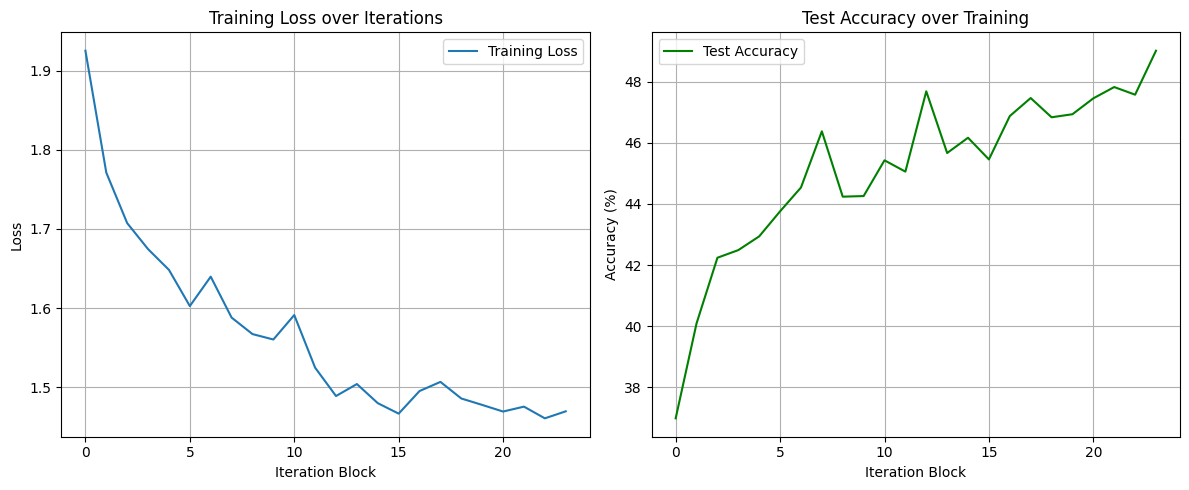

In [32]:


plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Iteration Block')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.legend()
plt.grid(True)

# Plot Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(test_acc_list, label='Test Accuracy', color='green')
plt.xlabel('Iteration Block')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Training')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



Okay, so far, the loss decreasing is very unsmooth and the test accuracy rises and drops significantly, this could be due to a larger learning rate. Hypothesis is that reducing learning rate will lead to smoother curves. We also tweak the batch size to 8 and increase the dimension of the hidden layer to 512.

In [33]:
PATH = './cifar_onehidnoconvnet.pth'
torch.save(net.state_dict(), PATH)


In [34]:
net = oneHidden_noconv()  # Recreate the model architecture
net.load_state_dict(torch.load('./cifar_onehidnoconvnet.pth'))
net.eval()  # Set to evaluation mode

oneHidden_noconv(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (ReLU): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [35]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 48 %


In [36]:
def get_model():
    return oneHidden_noconv()  # function to create a new instance of the model during every hyper-paramater tune


In [37]:
learning_rates = [0.0001]
momentums = [0.9, 0.95]
batch_sizes = [4, 8]

# Store results
results = []

# Grid search
for lr, momentum, batch_size in product(learning_rates, momentums, batch_sizes):
    print(f"\n🔧 Training with lr={lr}, momentum={momentum}, batch_size={batch_size}")
    
    # Reinitialize model, optimizer, criterion, dataloaders
    net = get_model()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    criterion = nn.CrossEntropyLoss()
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)



    # Training loop
    for epoch in range(5):
        for i, data in enumerate(trainloader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate final test accuracy
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for test_data in testloader:
            test_inputs, test_labels = test_data
            test_outputs = net(test_inputs)
            _, test_predicted = torch.max(test_outputs.data, 1)
            total += test_labels.size(0)
            correct += (test_predicted == test_labels).sum().item()
    test_accuracy = 100.0 * correct / total
    results.append(((lr, momentum, batch_size), test_accuracy))
    print(f" Final Test Accuracy: {test_accuracy:.2f}%")

# Summary
print("\n Summary of All Configurations:")
for config, acc in results:
    print(f"lr={config[0]}, momentum={config[1]}, batch_size={config[2]} => Accuracy: {acc:.2f}%")

best = max(results, key=lambda x: x[1])
print(f"\n Best Configuration: lr={best[0][0]}, momentum={best[0][1]}, batch_size={best[0][2]} => Accuracy: {best[1]:.2f}%")


🔧 Training with lr=0.0001, momentum=0.9, batch_size=4
 Final Test Accuracy: 50.18%

🔧 Training with lr=0.0001, momentum=0.9, batch_size=8
 Final Test Accuracy: 48.24%

🔧 Training with lr=0.0001, momentum=0.95, batch_size=4
 Final Test Accuracy: 52.56%

🔧 Training with lr=0.0001, momentum=0.95, batch_size=8
 Final Test Accuracy: 51.01%

 Summary of All Configurations:
lr=0.0001, momentum=0.9, batch_size=4 => Accuracy: 50.18%
lr=0.0001, momentum=0.9, batch_size=8 => Accuracy: 48.24%
lr=0.0001, momentum=0.95, batch_size=4 => Accuracy: 52.56%
lr=0.0001, momentum=0.95, batch_size=8 => Accuracy: 51.01%

 Best Configuration: lr=0.0001, momentum=0.95, batch_size=4 => Accuracy: 52.56%
